# CT Medical Image Analysis 

## Dataset 

The dataset is from [Kaggle](https://www.kaggle.com/kmader/siim-medical-image-analysis-tutorial) which was from [TCIA]( https://wiki.cancerimagingarchive.net/display/Public/TCGA-LUAD)  
   


The dataset is designed to allow for different methods to be tested for examining the trends in CT image data associated with using contrast and patient age. The basic idea is to identify image textures, statistical patterns and features correlating strongly with these traits and possibly build simple tools for automatically classifying these images when they have been misclassified (or finding outliers which could be suspicious cases, bad measurements, or poorly calibrated machines)  
  
The data are a tiny subset of images from the cancer imaging archive. They consist of the middle slice of all CT images taken where valid age, modality, and contrast tags could be found. This results in 475 series from 69 different patients.

## Data Citation 

Albertina, B., Watson, M., Holback, C., Jarosz, R., Kirk, S., Lee, Y., … Lemmerman, J. (2016). Radiology Data from The Cancer Genome Atlas Lung Adenocarcinoma [TCGA-LUAD] collection. The Cancer Imaging Archive. http://doi.org/10.7937/K9/TCIA.2016.JGNIHEP5

## TCIA Citation 

Clark K, Vendt B, Smith K, Freymann J, Kirby J, Koppel P, Moore S, Phillips S, Maffitt D, Pringle M, Tarbox L, Prior F. The Cancer Imaging Archive (TCIA): Maintaining and Operating a Public Information Repository, Journal of Digital Imaging, Volume 26, Number 6, December, 2013, pp 1045-1057. (paper)

## Step 1 

Import the packages.

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np # matrix tools
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for basic plots
import seaborn as sns # for nicer plots
import time
import os
import math
import tensorflow as tf

In [14]:
from glob import glob
glob('dicom_dir/*')

['dicom_dir\\ID_0000_AGE_0060_CONTRAST_1_CT.dcm',
 'dicom_dir\\ID_0001_AGE_0069_CONTRAST_1_CT.dcm',
 'dicom_dir\\ID_0002_AGE_0074_CONTRAST_1_CT.dcm',
 'dicom_dir\\ID_0003_AGE_0075_CONTRAST_1_CT.dcm',
 'dicom_dir\\ID_0004_AGE_0056_CONTRAST_1_CT.dcm',
 'dicom_dir\\ID_0005_AGE_0048_CONTRAST_1_CT.dcm',
 'dicom_dir\\ID_0006_AGE_0075_CONTRAST_1_CT.dcm',
 'dicom_dir\\ID_0007_AGE_0061_CONTRAST_1_CT.dcm',
 'dicom_dir\\ID_0008_AGE_0051_CONTRAST_1_CT.dcm',
 'dicom_dir\\ID_0009_AGE_0048_CONTRAST_1_CT.dcm',
 'dicom_dir\\ID_0010_AGE_0060_CONTRAST_1_CT.dcm',
 'dicom_dir\\ID_0011_AGE_0061_CONTRAST_1_CT.dcm',
 'dicom_dir\\ID_0012_AGE_0061_CONTRAST_1_CT.dcm',
 'dicom_dir\\ID_0013_AGE_0060_CONTRAST_1_CT.dcm',
 'dicom_dir\\ID_0014_AGE_0071_CONTRAST_1_CT.dcm',
 'dicom_dir\\ID_0015_AGE_0061_CONTRAST_1_CT.dcm',
 'dicom_dir\\ID_0016_AGE_0063_CONTRAST_1_CT.dcm',
 'dicom_dir\\ID_0017_AGE_0060_CONTRAST_1_CT.dcm',
 'dicom_dir\\ID_0018_AGE_0074_CONTRAST_1_CT.dcm',
 'dicom_dir\\ID_0019_AGE_0070_CONTRAST_1_CT.dcm',


Show the examles of the data.

In [7]:
overview_df = pd.read_csv('overview.csv')
overview_df.columns = ['idx']+list(overview_df.columns[1:])
overview_df['Contrast'] = overview_df['Contrast'].map(lambda x: 'Contrast' if x else 'No Contrast')
overview_df.sample(3)

,idx,Age,Contrast,ContrastTag,raw_input_path,id,tiff_name,dicom_name
33,33,71,Contrast,NONE,../data/50_50_dicom_cases\Contrast\00001 (4).dcm,33,ID_0033_AGE_0071_CONTRAST_1_CT.tif,ID_0033_AGE_0071_CONTRAST_1_CT.dcm
68,68,72,No Contrast,NONE,../data/50_50_dicom_cases\No contrast\000001 (...,68,ID_0068_AGE_0072_CONTRAST_0_CT.tif,ID_0068_AGE_0072_CONTRAST_0_CT.dcm
82,82,47,No Contrast,NONE,../data/50_50_dicom_cases\No contrast\000001 (...,82,ID_0082_AGE_0047_CONTRAST_0_CT.tif,ID_0082_AGE_0047_CONTRAST_0_CT.dcm


Show a histagram of the age distribution.

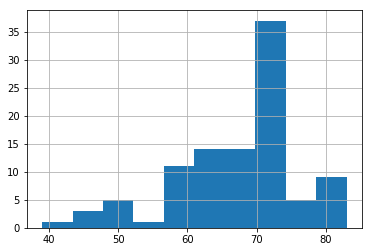

In [10]:
overview_df['Age'].hist()
plt.show()

Show a single slice.

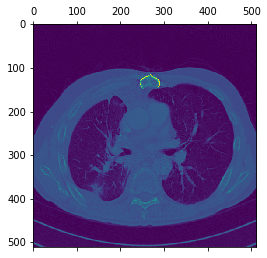

In [19]:
with np.load('full_archive.npz') as im_data:
    # make a dictionary of the data vs idx
    full_image_dict = dict(zip(im_data['idx'], im_data['image']))
    
plt.matshow(full_image_dict[0])
plt.show()

## Step 2  (Feature Extraction)


Now we calculate a simple feature like the mean intensity in the image and show how it relates to age and contrast.

In [20]:
overview_df['MeanHU'] = overview_df['idx'].map(lambda x: np.mean(full_image_dict.get(x, np.zeros((512,512)))))
overview_df['StdHU'] = overview_df['idx'].map(lambda x: np.std(full_image_dict.get(x, np.zeros((512,512)))))
overview_df.sample(3)

,idx,Age,Contrast,ContrastTag,raw_input_path,id,tiff_name,dicom_name,MeanHU,StdHU
81,81,58,No Contrast,NONE,../data/50_50_dicom_cases\No contrast\000001 (...,81,ID_0081_AGE_0058_CONTRAST_0_CT.tif,ID_0081_AGE_0058_CONTRAST_0_CT.dcm,-643.856571,454.209754
74,74,74,No Contrast,NONE,../data/50_50_dicom_cases\No contrast\000001 (...,74,ID_0074_AGE_0074_CONTRAST_0_CT.tif,ID_0074_AGE_0074_CONTRAST_0_CT.dcm,-464.048973,487.298433
63,63,73,No Contrast,NONE,../data/50_50_dicom_cases\No contrast\000001 (...,63,ID_0063_AGE_0073_CONTRAST_0_CT.tif,ID_0063_AGE_0073_CONTRAST_0_CT.dcm,-470.732224,496.474121


We show a pair plot of all variables to see if there are any interesting overlaps.

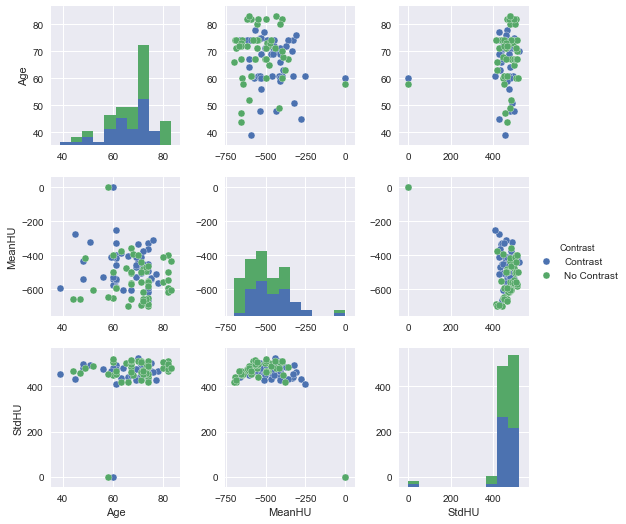

In [23]:
sns.set()
_ = sns.pairplot(overview_df[['Age', 'Contrast', 'MeanHU', 'StdHU']], hue="Contrast")

plt.show()